## Canine GWAS Target Sample Selection

Steps:
    
- Merge reference and target datasets
- Filter to autosomes
- Run PCA on the merged dataset filtered to reference samples
- Investigate high loadings
- Potentially re-run PCA if SNPs need to be removed
- Project all target samples onto the reference PCA space
- Select target samples in the neighborhood of a homogeneous labeled population (Boxers)
- **Output**: A table containing the samples to filter to

The purpose of PCA applied in this pipeline will be to decompose population structure.  This "population structure" is broadly defined as ([Li et al. 2010](https://academic.oup.com/bioinformatics/article/26/6/798/244373)):

> Population stratification refers to the presence of a systematic difference in allele frequencies between subpopulations in a study due to ancestry difference between study subjects. Unrecognized population stratification can lead to both false-positive and false-negative findings and can obscure the true association signals if not appropriately corrected.

It is also thought to consist of several types of systematic differences:

- **Discrete population structure**
    > Consists of populations that are remotely related (such as Europeans, Africans and Asians) and the population structure is easy to discern as the individuals are clearly separated. 
- **Admixed population structure**
    > Consists of subjects of admixed ancestry (such as African Americans and Hispanic Americans) with different individuals having different degrees of admixture, and that cannot be separated into discrete clusters. Intercontinental gradients can also be considered as admixed, although the degree of admixture is smaller than African Americans and Hispanic Americans
- **Hierarchical population structure** 
    > Consists of both discrete and admixed population structures. Hierarchical population structures may be seen in studies that involve multi-ethnic cohorts, which are becoming increasingly common in genetics consortiums.

Inferring such structure is an important precursor to applying QC operations that rely on statistics applicable only to homogeneous populations (of common ancestry).  The methods below reflect what was done as a part of the UKBB QC process for identifying homogenous populations within which to calculate HWE and MAF statistics.  

In [1]:
import os
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os.path as osp
import functools
from IPython.display import Image
from gwas_analysis import pca
from gwas_analysis import viz
%run {os.environ['NB_DIR']}/nb.py
%run paths.py
%run common.py
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://26f521ec4dc5:4041
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.32-a5876a0a2853
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200218-1414-0.2.32-a5876a0a2853.log


### Load Target and Reference Data

In [2]:
%%capture
hl.ReferenceGenome(**load_reference_genome(REF_GENOME_FILE))

In [3]:
mt_ref = hl.read_matrix_table(osp.join(WORK_DIR, REF_QC_03_FILE + '.mt'))
mt_ref = mt_ref.drop('pcs')
mt_ref = mt_ref.annotate_cols(source='ref')
mt_ref = mt_ref.key_cols_by('source', 's')
mt_ref.count()

(36332, 1350)

In [4]:
mt_tgt = hl.import_plink(
    *plink_files(ORGANISM_CANINE_TGT_DIR, PLINK_FILE_TGT),
    skip_invalid_loci=False,
    reference_genome='canine'
)
mt_tgt = mt_tgt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
mt_tgt = mt_tgt.annotate_cols(source='tgt')
mt_tgt = mt_tgt.key_cols_by('source', 's')
mt_tgt.count()

2020-02-18 14:14:12 Hail: INFO: Found 4342 samples in fam file.
2020-02-18 14:14:12 Hail: INFO: Found 160727 variants in bim file.
2020-02-18 14:14:13 Hail: INFO: Coerced sorted dataset


(160727, 4342)

### Merge Datasets

In [5]:
%%time 
# Resolve minor schema conflicts
def prep_ref(mt):
    mt = mt.drop('pcs')
    return mt.key_cols_by('source', 's')

def prep_tgt(mt):
    mt = mt.annotate_cols(**{c: hl.null(hl.tstr) for c in ['breed', 'breed_clade', 'breed_name']})
    return mt.key_cols_by('source', 's')
    
# Concatenate along sample axis, joining to only shared variants (by locus and allele)
mt = mt_ref.union_cols(mt_tgt, row_join_type='inner')

# After the merge, there should be as many variants left as there
# were originally in the reference dataset
assert mt.count()[0] == mt_ref.count()[0]

# Filter to autosomes (which means chrosome 1-38 for dogs)
mt = mt.filter_rows(mt.locus.in_autosome())
mt.count()

2020-02-18 14:14:15 Hail: INFO: Coerced sorted dataset
2020-02-18 14:14:16 Hail: INFO: Coerced sorted dataset


CPU times: user 38.5 ms, sys: 3.06 ms, total: 41.6 ms
Wall time: 2.12 s


(36332, 5692)

In [6]:
# Utility functions

def get_pc_score_fig_data(ht, pc1, pc2, *fields):
    lbl = (f'PC{pc1+1:02d}', f'PC{pc2+1:02d}')
    annots = {lbl[0]: ht.scores[pc1], lbl[1]: ht.scores[pc2]}
    for f in fields:
        annots[f] = ht[f]
    return ht.annotate(**annots).key_by().to_pandas()
    
def get_pc_score_fig(df, **kwargs):
    pcs = sorted(df.filter(regex='PC\d{2}').columns.tolist())
    return px.scatter(df, x=pcs[0], y=pcs[1], **kwargs)

def add_sample_info(ht, ht_info, fields=['breed', 'breed_name', 'breed_clade']):
    return ht.annotate(**{c: ht_info[ht.key][c] for c in fields})

### Raw PCA 

Before running PCA on a curated sample, it is helpful to see first how results will look using raw data.  This makes for a helpful contrast with later findings.  Some of this is motivated by [Privé et al. 2018](https://academic.oup.com/bioinformatics/article/34/16/2781/4956666) (see [bigsnpr/how-to-PCA](https://privefl.github.io/bigsnpr/articles/how-to-PCA.html)).

In [7]:
%%time
# Run PCA on the target dataset w/o first merging to curated reference set with pruned variants
pc_scores, pc_loadings = pca.utils.hwe_normalized_pca(mt_tgt)[1:]

2020-02-18 14:14:24 Hail: INFO: Coerced sorted dataset
2020-02-18 14:14:37 Hail: INFO: hwe_normalized_pca: running PCA using 160727 variants.
2020-02-18 14:14:37 Hail: INFO: Coerced sorted dataset
2020-02-18 14:14:55 Hail: INFO: pca: running PCA with 10 components...


CPU times: user 124 ms, sys: 14.1 ms, total: 138 ms
Wall time: 1min 24s


2020-02-18 14:15:48 Hail: INFO: Coerced sorted dataset


2020-02-18 14:15:48 Hail: INFO: Ordering unsorted dataset with network shuffle


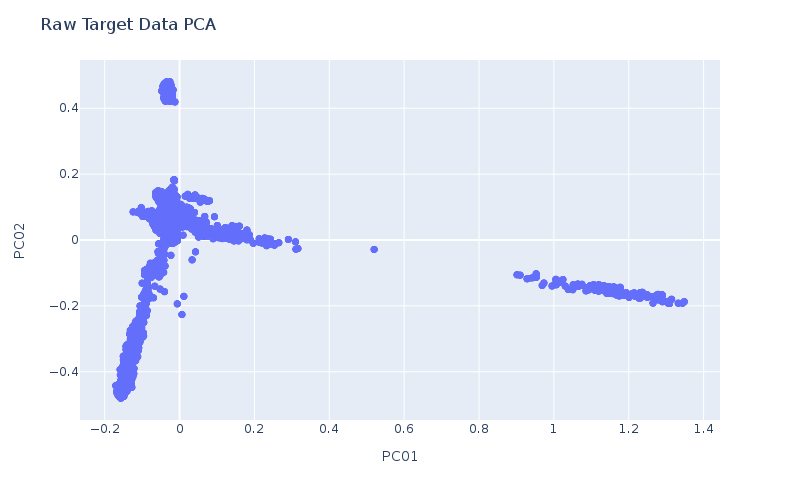

In [8]:
fig = get_pc_score_fig(get_pc_score_fig_data(pc_scores, 0, 1))
fig.update_layout(title='Raw Target Data PCA')
Image(fig.to_image('png', width=800, height=500))

The first two PCs indicate that there may be some meaninful separation.  However, it is important with PCA of bi-allelic variants to understand what the principal components capture.  This is often done using the loadings, which are shown below and indicate the variance-weighted coefficient (aka eigenvalue-weighted eigenvectors) associated with an individual SNP and PC. 

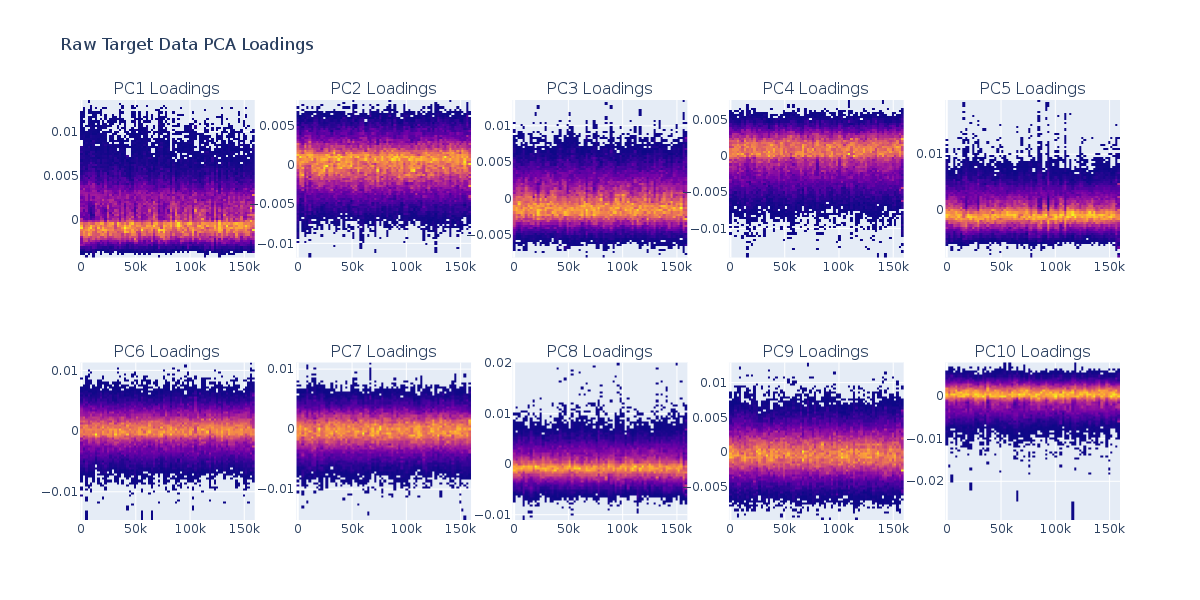

In [9]:
fig = pca.viz.get_loadings_fig(pca.viz.get_loadings_df(pc_loadings))
fig.update_layout(title='Raw Target Data PCA Loadings')
Image(fig.to_image('png', width=1200, height=600))

The x axis above indicates the index within the dataset of a variant/SNP.  They y axis corresponds to the PC loading for a SNP at a given index.  Both axes are binned for speed of visualization.  We see many peaks and skewed distributions for these loadings where we would otherwise expect roughly normaly distributed loadings values if a PC is capturing broader population structure.  Later examples will explain what some of these peaks mean and why much of the variation here is likely related to linkage disequilibrium (LD) rather than population structure.

### QC PCA 

Run an initial round of PCA on the reference dataset and determine whether or not any SNPs with high loadings should be manually removed.

In [10]:
def pca_fit_project(mt_ref, mt_tgt, n_pcs=10):
    pc_evals_ref, pc_scores_ref, pc_loadings_ref = pca.utils.hwe_normalized_pca(mt_ref, n_pcs=n_pcs)
    pc_scores_tgt = pca.utils.pc_project(mt_tgt, pc_loadings_ref)
    return (pc_scores_ref, pc_scores_tgt), pc_loadings_ref, np.array(pc_evals_ref)

In [11]:
%%time
pc_scores, pc_loadings_ref, pc_evals_ref = pca_fit_project(mt.filter_cols(mt.source=='ref'), mt.filter_cols(mt.source=='tgt'), n_pcs=10)
assert pc_scores[0].count() + pc_scores[1].count() == mt.count()[1]

2020-02-18 14:16:12 Hail: INFO: Coerced sorted dataset
2020-02-18 14:16:23 Hail: INFO: hwe_normalized_pca: running PCA using 36332 variants.
2020-02-18 14:16:24 Hail: INFO: Coerced sorted dataset
2020-02-18 14:16:35 Hail: INFO: pca: running PCA with 10 components...
2020-02-18 14:17:01 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:02 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2020-02-18 14:17:02 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:03 Hail: INFO: Coerced sorted dataset


CPU times: user 218 ms, sys: 11.4 ms, total: 229 ms
Wall time: 51.4 s


2020-02-18 14:17:04 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:04 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:04 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:04 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 14:17:05 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:05 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:05 Hail: INFO: Coerced sorted dataset


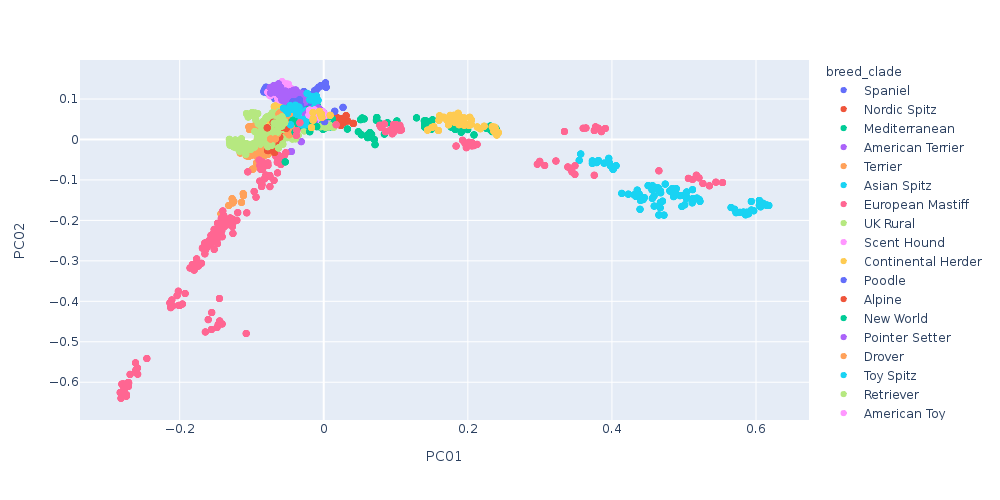

In [12]:
ht = add_sample_info(pc_scores[0], mt.filter_cols(mt.source=='ref').cols())
fig = get_pc_score_fig(get_pc_score_fig_data(ht, 0, 1), color='breed_clade')
Image(fig.to_image('png', width=1000, height=500))

Show scree plot, which will indicate the factor by which a PC explains more of the total variance than another (e.g. PC1 explains approximately 3x more of the total variance than PC4):

**NOTE**: The absolute explained variance would be more informative, but this would require computing the full covariance matrix to get total variance in the dataset.  This is left out since it is computationally expensive and not ultimately necessary to relate samples in our two datasets.

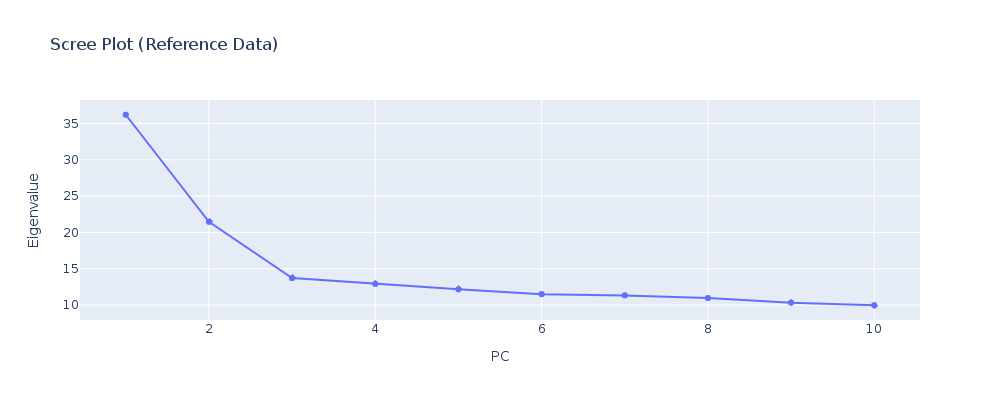

In [13]:
fig = px.scatter(x=np.arange(len(pc_evals_ref))+1, y=pc_evals_ref, title='Scree Plot (Reference Data)')
fig.data[0].update(mode='markers+lines')
fig.update_xaxes(title='PC')
fig.update_yaxes(title='Eigenvalue')
Image(fig.to_image('png', width=1000, height=400))

#### Loadings

Compared to loadings for the raw data, this decomposition shows many fewer peaks.  This is primarily because it was run on a dataset with highly correlated SNPs removed.

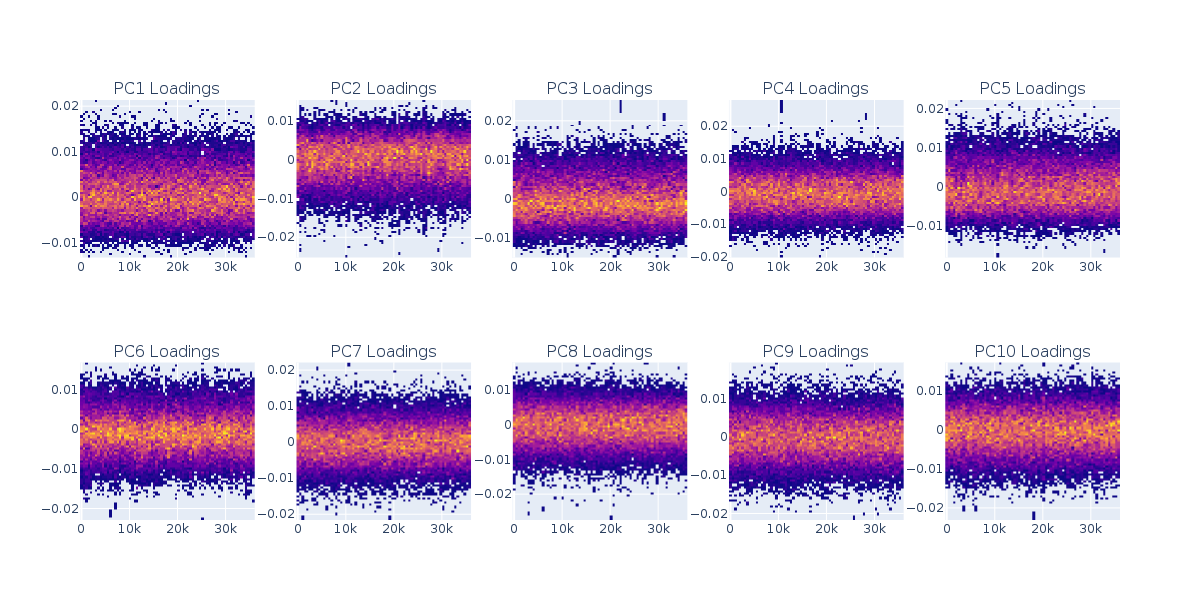

In [14]:
fig = pca.viz.get_loadings_fig(pca.viz.get_loadings_df(pc_loadings_ref))
Image(fig.to_image('png', width=1200, height=600))

We can see above that there are a few suspicious peaks though, for example in **PC3** and **PC4**.  The UKBB QC process involves identifying such large loadings and eliminating the associated SNPs (probably just in the first two PCs).  There are no further details than that provided so in this analysis we will investigate them more closely before deciding what to do about them.

**NOTE**: LD will be used interchangeably with the concept of Pearson correlation in this analysis because Hail defines it that way (LD = Perason $r$ between vectors of alt allele counts).  This should not be confused with $D'$ ([Lewontin 1964](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1210557/)).

#### LD Assertion

First, we will check that our original dataset didn't have any variants in high LD w/ one another.  This should not be possible at this point in the pipeline (downstream from pruning), but it will be asserted anyhow.

In [15]:
def get_ld_matrix(mt, bp_window_size=1000000):
    bm = hl.ld_matrix(mt.GT.n_alt_alleles(), mt.locus, radius=bp_window_size)
    bm = bm.sparsify_triangle()
    return bm
ld = get_ld_matrix(mt.filter_cols(mt.source=='ref')).entries()
ld = ld.filter(ld.i != ld.j)
hist = ld.aggregate(hl.agg.hist(ld.entry, -1.01, 1.01, 128))
ld.describe()

2020-02-18 14:17:11 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:12 Hail: INFO: Coerced sorted dataset
2020-02-18 14:17:42 Hail: INFO: Wrote all 9 blocks of 36332 x 1350 matrix with block size 4096.
2020-02-18 14:17:43 Hail: INFO: Coerced sorted dataset


----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'i': int64 
    'j': int64 
    'entry': float64 
----------------------------------------
Key: ['i', 'j']
----------------------------------------


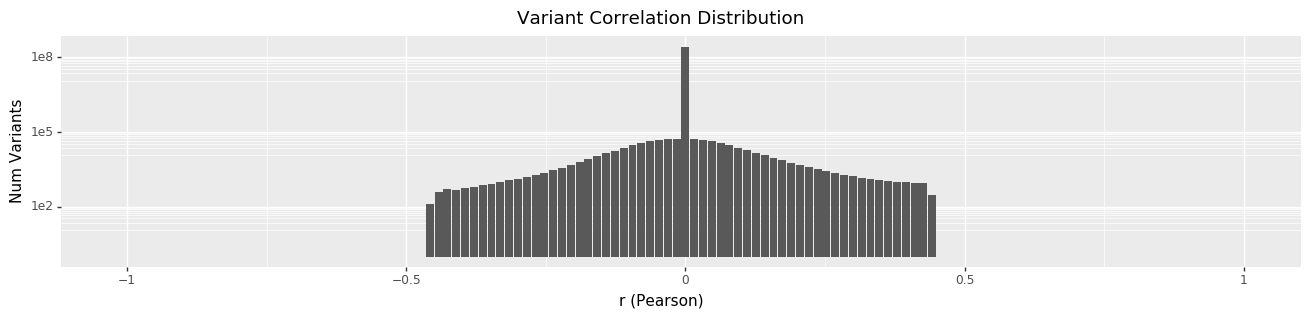

<ggplot: (8746822710413)>

In [22]:
# This should have no density near -1 or 1
(
    pn.ggplot(
        pd.DataFrame(dict(x=hist.bin_edges[:-1], y=hist.bin_freq))
        .assign(y=lambda df: df['y'] + 1),
        pn.aes(x='x', y='y')
    ) + 
    pn.geom_bar(stat='identity') + 
    pn.scale_y_log10() + 
    pn.labs(x='r (Pearson)', y='Num Variants', title='Variant Correlation Distribution') +
    pn.theme(figure_size=(16, 3))
)

In [23]:
max_r2 = ld.aggregate(hl.agg.max(ld.entry)**2)
assert max_r2 <= .2 # This was the ld_prune threshold used
max_r2

0.19999597651695786

No issues here -- any SNPs with high loadings in nearby genomic positions could still be capturing weak LD, but that would only happen if there aren't more dominant sources of variation.  We would expect more dominant phylogenetic causes of variation to exist given the large ancestral diversity of the NHGRI dog data.

#### SNPs

The small number high loading values found above may be due to PCs that capture LD (which we don't want) or they may be due to valid components of population structure attributable to a small number of SNPs.  We can differentiate between the two by determining whether or not the SNPs with high loadings can be used to differentiate populations.  If they cannot, then we can be reasonably certain that they should be excluded from the remainder of this part of the QC process.

One way to better understand the distinction between LD and population structure is to imagine a scenario where a number of nearby SNPs each have nearly the same genotypes for all samples (i.e. they are independent of populations) and are highly correlated (i.e. in LD) with each other.  In this case, PCA will likely capture this axis of variation even though it has no relevance to what makes the populations different.  If we were to then use this axis as part of an analysis that is attempting to map populations to each other across datasets, that analysis would be flawed.  It would not have determined what samples are similar to others in a way that reflects ancestry.

The operations below will identify the SNPS with high loadings for **PC3** and **PC4** and show how genotypes for those SNPs related to population structure.

In [16]:
def extract_loading(ht, pc):
    """ Extract table containing loading vector for a single PC"""
    df = ht.transmute(loading=ht.loadings[pc-1]).to_pandas()
    # Order result by loading absolute value
    df['loading_abs'] = df['loading'].abs()
    df = df.sort_values('loading_abs', ascending=False)
    df['rank'] = np.arange(len(df))
    return df.assign(pc=pc)
df_loading = (
    pd.concat([
        extract_loading(pc_loadings_ref, 3),
        extract_loading(pc_loadings_ref, 4)
    ])
    .rename_axis('snp_idx', axis='index')
    .set_index('pc', append=True).reorder_levels([1, 0], axis=0)
)
df_loading.head()

2020-02-18 14:18:40 Hail: INFO: Coerced sorted dataset
2020-02-18 14:18:51 Hail: INFO: Coerced sorted dataset


locus.contig  locus.position alleles    pca_af   loading  \
pc snp_idx                                                            
3  22464             21        31222845  [C, A]  0.097407  0.024204   
   31333             32         8849138  [A, G]  0.124074  0.020921   
   14101             13        11683646  [A, C]  0.121852  0.019475   
   34978             37          428306  [G, A]  0.115356  0.019155   
   31629             32        21596466  [A, C]  0.120741  0.018936   

            loading_abs  rank  
pc snp_idx                     
3  22464       0.024204     0  
   31333       0.020921     1  
   14101       0.019475     2  
   34978       0.019155     3  
   31629       0.018936     4

Show the top loadings for the selected PCs:

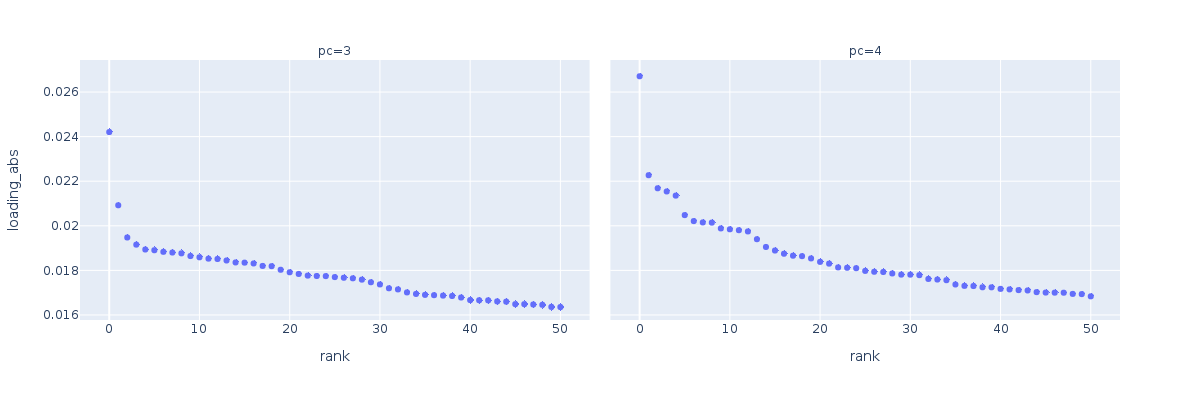

In [17]:
fig = px.scatter(
    df_loading.pipe(lambda df: df[df['rank'] <= 50]).reset_index(), 
    x='rank', y='loading_abs', facet_col='pc'
)
Image(fig.to_image('png', width=1200, height=400))

Filter by rank to the top 10 and see how closely some of them cluster by position (in the genome):

In [18]:
df_loading.groupby('pc', group_keys=False).head(10).sort_values(['pc', 'locus.contig', 'locus.position'])

locus.contig  locus.position alleles    pca_af   loading  \
pc snp_idx                                                            
3  12221             11        33576744  [G, A]  0.182593  0.018833   
   14101             13        11683646  [A, C]  0.121852  0.019475   
   22464             21        31222845  [C, A]  0.097407  0.024204   
   24900             23        49928161  [G, A]  0.062222  0.018904   
   28505             28        18445990  [A, G]  0.112472  0.018801   
   3157               3        29753457  [G, A]  0.087407  0.018644   
   31333             32         8849138  [A, G]  0.124074  0.020921   
   31629             32        21596466  [A, C]  0.120741  0.018936   
   34978             37          428306  [G, A]  0.115356  0.019155   
   7950               7        17231924  [G, A]  0.085926  0.018764   
4  10870             10         7504397  [A, G]  0.501852  0.021353   
   10871             10         8483885  [C, A]  0.335185  0.026707   
   10873             10         8772534  [A, G]  0.372774 -0.019883   
   12746             11        73113786  [A, G]  0.292593  0.020211   
   19055             17        56295050  [G, A]  0.182222  0.020152   
   21414             20        21966757  [G, A]  0.424444  0.021540   
   27063             26        24104930  [G, A]  0.283173  0.021683   
   28614             28        23197124  [A, G]  0.271481  0.022269   
   31030             31        33058366  [G, A]  0.288519  0.020143   
   8116               7        30192966  [A, G]  0.262787  0.020480   

            loading_abs  rank  
pc snp_idx                     
3  12221       0.018833     6  
   14101       0.019475     2  
   22464       0.024204     0  
   24900       0.018904     5  
   28505       0.018801     7  
   3157        0.018644     9  
   31333       0.020921     1  
   31629       0.018936     4  
   34978       0.019155     3  
   7950        0.018764     8  
4  10870       0.021353     4  
   10871       0.026707     0  
   10873       0.019883     9  
   12746       0.020211     6  
   19055       0.020152     7  
   21414       0.021540     3  
   27063       0.021683     2  
   28614       0.022269     1  
   31030       0.020143     8  
   8116        0.020480     5

Of the top SNPs above, choose only those that correspond to peaks in the loadings (they have nearby snp_index values):

In [19]:
snp_indexes = [
    (3, 22464), (3, 24900), (3, 28505),
    (3, 31333), (3, 31629), (3, 34978),
    (4, 10870), (4, 10871), (4, 10873)
]
df_loading.loc[snp_indexes]

locus.contig  locus.position alleles    pca_af   loading  \
pc snp_idx                                                            
3  22464             21        31222845  [C, A]  0.097407  0.024204   
   24900             23        49928161  [G, A]  0.062222  0.018904   
   28505             28        18445990  [A, G]  0.112472  0.018801   
   31333             32         8849138  [A, G]  0.124074  0.020921   
   31629             32        21596466  [A, C]  0.120741  0.018936   
   34978             37          428306  [G, A]  0.115356  0.019155   
4  10870             10         7504397  [A, G]  0.501852  0.021353   
   10871             10         8483885  [C, A]  0.335185  0.026707   
   10873             10         8772534  [A, G]  0.372774 -0.019883   

            loading_abs  rank  
pc snp_idx                     
3  22464       0.024204     0  
   24900       0.018904     5  
   28505       0.018801     7  
   31333       0.020921     1  
   31629       0.018936     4  
   34978       0.019155     3  
4  10870       0.021353     4  
   10871       0.026707     0  
   10873       0.019883     9

Define genomic intervals to be used to aggregate alternate allele counts for samples across only the above variants:

In [20]:
locus_intervals = {
    pc: [
        dict(
            interval=hl.locus_interval(
                r['locus.contig'], r['locus.position'], r['locus.position'], 
                includes_end=True, reference_genome='canine'),
            sign=np.sign(r.loading)
        ) for i, r in g.iterrows()
    ]
    for pc, g in df_loading.loc[snp_indexes].reset_index().groupby('pc')
}
locus_intervals.keys()

dict_keys([3, 4])

Determine alt allele counts for the selected SNPs, for each sample:

In [21]:
# Summarize the genotype for a few select SNPs above
ht = mt.annotate_cols(**{
    f'allele_ct_pc{pc}': hl.agg.sum(
        functools.reduce(lambda a, b: a + b, [
            hl.if_else(
                i['interval'].contains(mt.locus), 
                mt.GT.n_alt_alleles() if i['sign'] > 0 else 2 - mt.GT.n_alt_alleles(), 
                0
            )
            for i in intervals
        ])
    )
    for pc, intervals in locus_intervals.items()
}).cols()
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    's': str 
    'fam_id': str 
    'pat_id': str 
    'mat_id': str 
    'is_female': bool 
    'is_case': bool 
    'breed': str 
    'breed_clade': str 
    'breed_name': str 
    'source': str 
    'allele_ct_pc3': int64 
    'allele_ct_pc4': int64 
----------------------------------------
Key: ['source', 's']
----------------------------------------


In [22]:
pcs = list(map(lambda v: v - 1, locus_intervals.keys()))
df = get_pc_score_fig_data(add_sample_info(pc_scores[0], ht, fields=[
    c for c in list(ht.row.keys()) if 'breed' in c or 'allele_ct' in c
]), pcs[0], pcs[1])
df.head()

2020-02-18 14:19:03 Hail: INFO: Coerced sorted dataset
2020-02-18 14:20:18 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:08 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:09 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:09 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:09 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:10 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:10 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 14:21:10 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:10 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:10 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:10 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:11 Hail: INFO: Coerced sorted dataset


,source,s,scores,breed,breed_clade,breed_name,allele_ct_pc3,allele_ct_pc4,PC03,PC04
0,ref,ACKR_09007,"[-0.06980552077763465, 0.12781224654315484, 0....",ACKR,Spaniel,American Cocker Spaniel,1,2,0.010012,-0.105930
1,ref,ACKR_09030,"[-0.05602680170439142, 0.11942991316047177, 0....",ACKR,Spaniel,American Cocker Spaniel,1,2,0.011987,-0.099656
2,ref,ACKR_09032,"[-0.06748035543012612, 0.11884565681668559, 0....",ACKR,Spaniel,American Cocker Spaniel,1,2,0.017122,-0.111990
3,ref,ACKR_09110,"[-0.05942921574527051, 0.12418446730185084, 0....",ACKR,Spaniel,American Cocker Spaniel,2,2,0.007932,-0.102813
4,ref,ACKR_09991,"[-0.050433350440257256, 0.13441171330800872, 0...",ACKR,Spaniel,American Cocker Spaniel,0,2,0.013039,-0.104214


Visualize PC3 vs PC4 colored by the number of alternate alleles:

Text(0.5, 0.98, 'PC03 vs PC04 colored by allele counts across selected proximal SNPs')

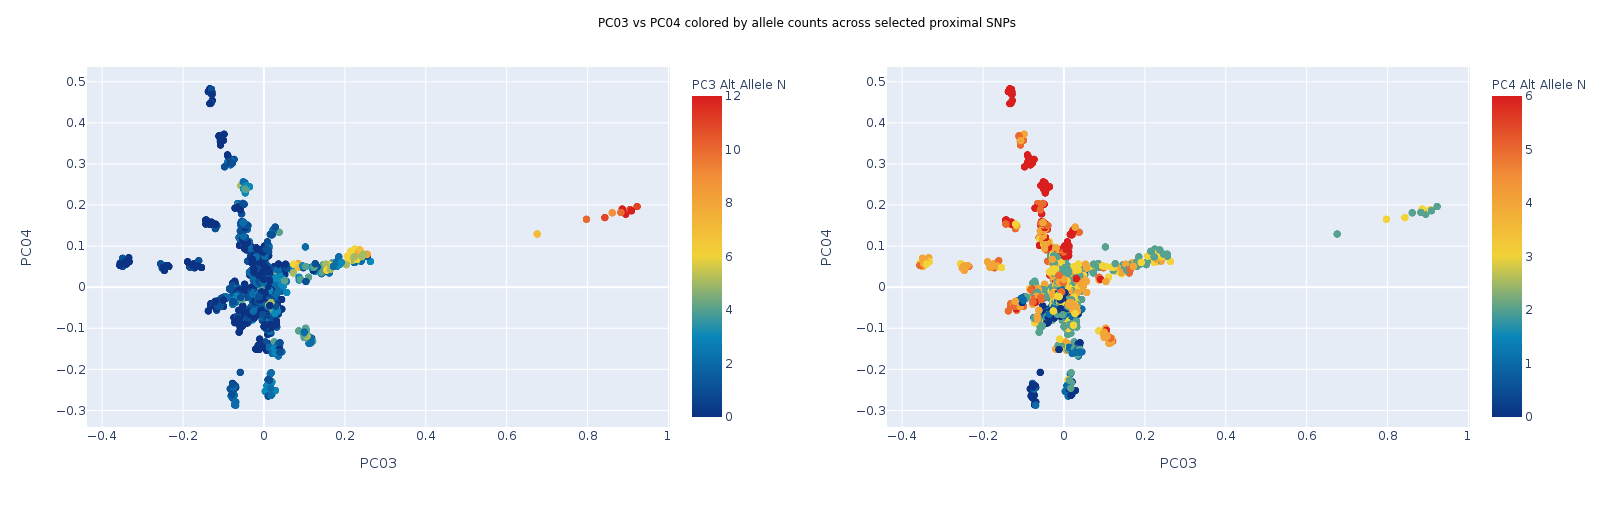

In [23]:
figs = [
    get_pc_score_fig(df.rename(
        columns={f'allele_ct_pc{pc+1}': f'PC{pc+1} Alt Allele N'}
    ), color=f'PC{pc+1} Alt Allele N', color_continuous_scale='Portland')
    for pc in pcs
]
breeds = [
    'Basenji', 'Irish Wolfhound', 'Shetland Sheepdog',
    'Collie', 'Saluki', 'Afghan Hound', 'Azawakh'
]
fig = get_pc_score_fig(
    df.assign(breed_name=lambda df: df['breed_name'].apply(lambda v: v if v in breeds else 'Other')), 
    color='breed_name', 
    color_discrete_map={'Other': 'grey'}
)
images = list(map(viz.png_bytes_to_numpy, map(lambda f: f.to_image('png', width=800, height=500), figs)))
viz.display_image_grid(images, 1, len(pcs))
plt.gcf().suptitle('PC03 vs PC04 colored by allele counts across selected proximal SNPs')

We can see above that even with just 9 variants it is possible to uniquely identify several clusters of samples.  These clusters correspond to breeds, as shown below, so we can be certain that these SNPs are important components of population structure:

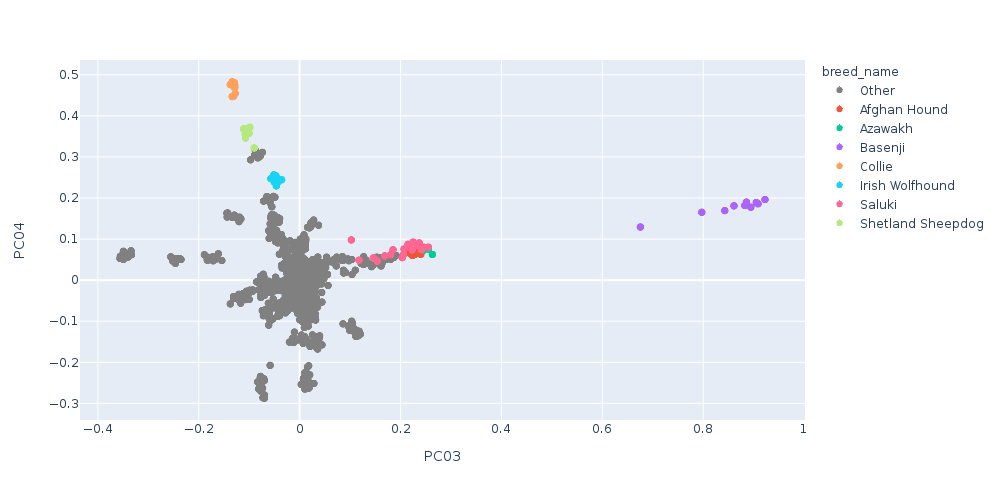

In [24]:
Image(fig.to_image('png', width=1000, height=500))

There are much more comprehensive methods for phylogenetic analysis using PCA such as [Jombart et al. 2010](https://bmcgenet.biomedcentral.com/articles/10.1186/1471-2156-11-94) (see [ppca](https://rdrr.io/cran/adephylo/man/ppca.html)), as well as many that do not use PCA, but this example provides intuition on how they work and accomplishes a much more specific goal in here in asserting that PCs are capturing population structure.

Similar comparisons of allele frequencies for SNPs with high PCA loadings can also be seen in [Genome-wide SNP and haplotype analyses reveal a rich history underlying dog domestication (vonHoldt 2010)](https://www.nature.com/articles/nature08837), where small numbers of highly ranked SNPs uniquely define genetic differences between dogs and grey wolves (see Supplemental Table 2).

## Target Data Projection

Show the target data projected onto the PCs from the reference data.  Additionally, identify samples in the target dataset that cluster closely to the Boxer samples in the reference data.  The Boxer population will be used because it is well isolated from other populations, fairly large compared to all other homogeneous populations in the target data, and because this breed was selected for similar reasons when sequencing the very first canine genome ([Lindblad-Toh et al. 2005](https://www.nature.com/articles/nature04338/)).  A passage from this publication reads:

> This particular animal was chosen for sequencing because it had the lowest heterozygosity rate among ∼120 dogs tested at a limited set of loci; subsequent analysis showed that the genome-wide heterozygosity rate in this boxer is not substantially different from other breeds (Parker 2004)

Despite the fact that Boxers may not have substantially lower heterozygosity than all other breeds, we will still use that breed in this analysis because it is very homogeneous within this dataset and it is the closest analog to the European cohort used in the UKBB pipeline.

In [25]:
%%time

# Extract PC scores for samples as well as necessary metadata
def get_projected_pc_data(pc_scores, n_pcs):
    ht = add_sample_info(pc_scores[0], mt.filter_cols(mt.source=='ref').cols())
    
    pcs = {f'PC{i+1}': ht.scores[i] for i in range(n_pcs)}
    df_ref = ht.select(
        **pcs,
        breed=ht.breed,
        breed_name=ht.breed_name,
        breed_clade=ht.breed_clade
    ).to_pandas()
    ht = pc_scores[1]
    pcs = {f'PC{i+1}': ht.scores[i] for i in range(n_pcs)}
    df_tgt = ht.select(**pcs).to_pandas()
    
    df = pd.concat([df_ref, df_tgt], sort=True)
    return df
df = get_projected_pc_data(pc_scores, 4)
df

2020-02-18 14:21:14 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:14 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:14 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:14 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-18 14:21:15 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:15 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:15 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:16 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:16 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:47 Hail: INFO: Coerced sorted dataset
2020-02-18 14:21:47 Hail: INFO: Coerced sorted dataset


,PC1,PC2,PC3,PC4,breed,breed_clade,breed_name,s,source
0,-0.069806,0.127812,0.010012,-0.105930,ACKR,Spaniel,American Cocker Spaniel,ACKR_09007,ref
1,-0.056027,0.119430,0.011987,-0.099656,ACKR,Spaniel,American Cocker Spaniel,ACKR_09030,ref
2,-0.067480,0.118846,0.017122,-0.111990,ACKR,Spaniel,American Cocker Spaniel,ACKR_09032,ref
3,-0.059429,0.124184,0.007932,-0.102813,ACKR,Spaniel,American Cocker Spaniel,ACKR_09110,ref
4,-0.050433,0.134412,0.013039,-0.104214,ACKR,Spaniel,American Cocker Spaniel,ACKR_09991,ref
...,...,...,...,...,...,...,...,...,...
4337,-0.037342,0.099134,0.017833,-0.043700,NaN,NaN,NaN,Wei_GT420,tgt
4338,-0.044805,0.099170,0.021749,-0.053177,NaN,NaN,NaN,Wei_GT421,tgt
4339,-0.035003,0.111565,0.017626,-0.052837,NaN,NaN,NaN,Wei_GT422,tgt
4340,-0.039574,0.104670,0.030836,-0.040192,NaN,NaN,NaN,Wei_GT423,tgt


In [26]:
%%time
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

# Cluster the target data samples within the PC1/PC2 space
dfc = df[df['source'] == 'tgt'].reset_index(drop=True)
dfc = dfc.rename_axis('index', axis='index')
dfc = dfc.set_index(['source', 's'], append=True).filter(regex='PC[12]').copy()
dfc['cluster'] = DBSCAN(eps=.02).fit_predict(dfc.values)

# Set the target breed in the reference data
target_breed = 'BOX'

# Determine the average distance between each point in the target data samples
# and all other boxer samples in the reference data
dfc['avg_dist'] = cdist(
    df[(df['source'] == 'ref') & (df['breed'] == 'BOX')].filter(regex='PC[12]').values, 
    df[df['source'] == 'tgt'].filter(regex='PC[12]').values
).mean(axis=0)

dfc.head()

CPU times: user 102 ms, sys: 11.9 ms, total: 114 ms
Wall time: 112 ms


,,,PC1,PC2,cluster,avg_dist
index,source,s,,,,
0,tgt,1023320,0.066445,0.012220,0,0.510998
1,tgt,1023575,0.060914,0.004531,0,0.501710
2,tgt,1024136,0.048031,0.019039,0,0.509863
3,tgt,1024163,0.064203,0.017041,0,0.514452
4,tgt,1027274,0.084900,0.006939,0,0.514272


In [27]:
# Find which of the clusters above has the lowest overall average distance to known Boxer samples
avg_distances = dfc.groupby('cluster')['avg_dist'].mean().sort_values()
target_cluster = avg_distances.idxmin()
avg_distances

cluster
 3     0.044064
 4     0.084791
 5     0.206171
 8     0.232374
 10    0.492908
 0     0.500671
-1     0.503637
 1     0.609497
 2     0.661255
 7     0.679287
 6     0.719997
 9     0.892746
Name: avg_dist, dtype: float64

Visualize several PC projections along with the newly selected target population:

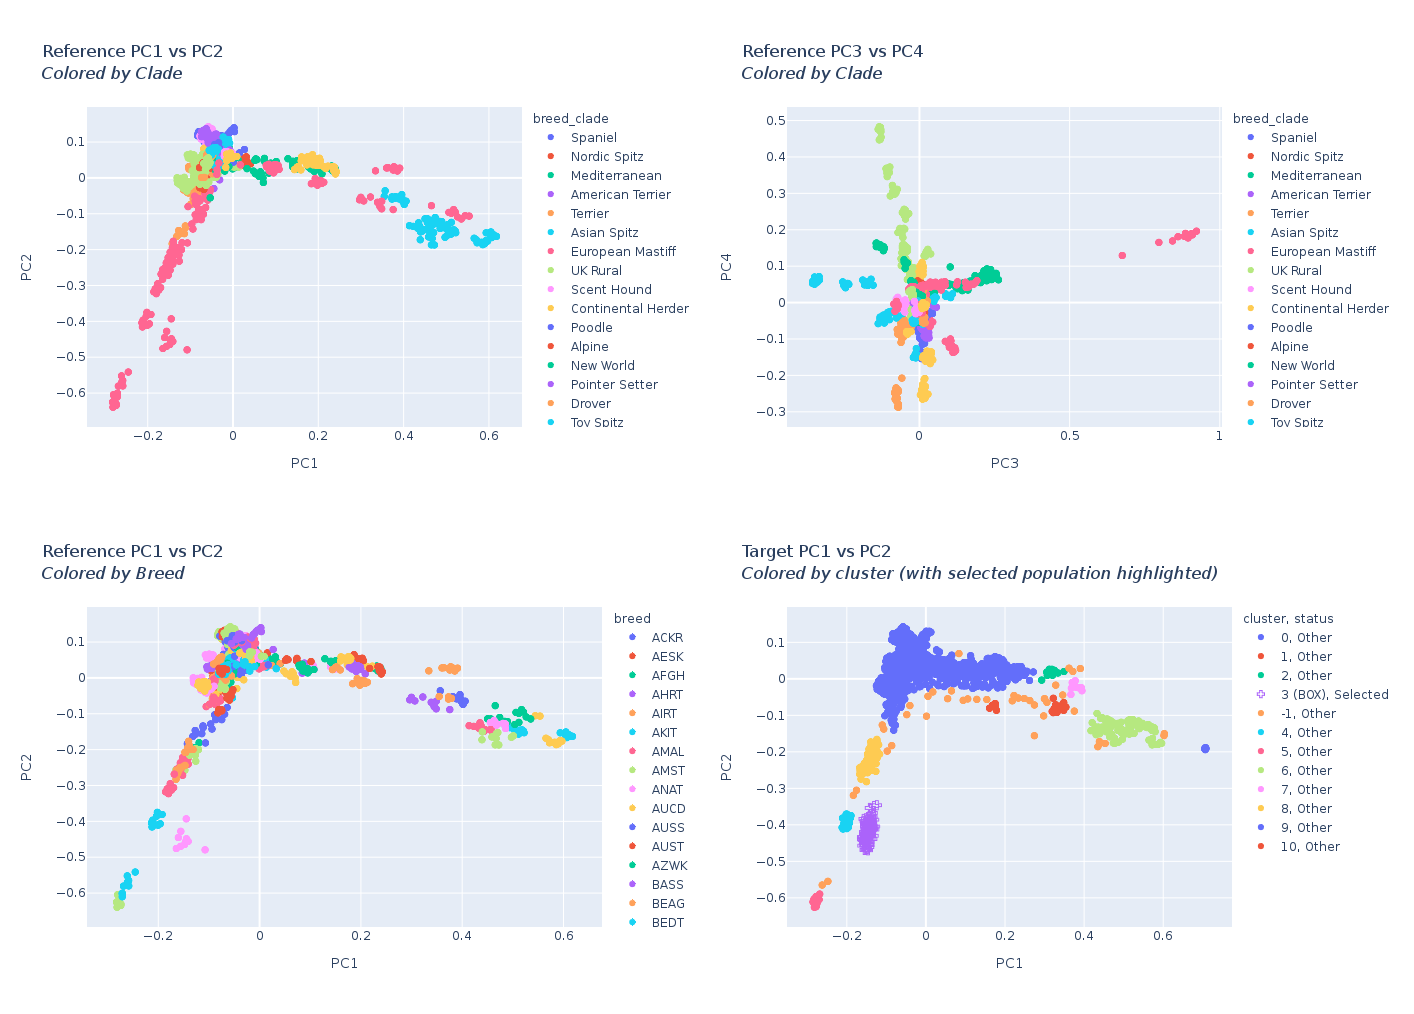

In [28]:
fig1 = px.scatter(
    df[df['source'] == 'ref'],
    x='PC1',
    y='PC2',
    color='breed_clade',
    hover_name='breed',
    title='Reference PC1 vs PC2<br><i>Colored by Clade</i>'
)
fig2 = px.scatter(
    df[df['source'] == 'ref'],
    x='PC3',
    y='PC4',
    color='breed_clade',
    hover_name='breed',
    title='Reference PC3 vs PC4<br><i>Colored by Clade</i>'
)
fig3 = px.scatter(
    df[df['source'] == 'ref'],
    x='PC1',
    y='PC2',
    color='breed',
    hover_name='breed',
    title='Reference PC1 vs PC2<br><i>Colored by Breed</i>'
)
fig4 = px.scatter(
    dfc.assign(
        status=lambda df: (df['cluster'] == target_cluster).map({True: 'Selected', False: 'Other'}),
        cluster=lambda df: df['cluster'].apply(
            lambda c: c if c != target_cluster else f'{c} ({target_breed})').astype(str)
    ),
    x='PC1',
    y='PC2',
    color='cluster',
    symbol='status',
    symbol_map={'Selected': 'cross-open', 'Other': 'circle'},
    title='Target PC1 vs PC2<br><i>Colored by cluster (with selected population highlighted)</i>'
)
viz.display_figure_grid([fig1, fig2, fig3, fig4], 2, 2)

###### Interactive Plots

Show the interactive versions of the top 2 plots above (must view with JS enabled, e.g. w/ https://nbviewer.jupyter.org/).

In [34]:
fig3

In [35]:
fig4

## Export

Export the selected samples in the target dataset.  These will be used in the next step for target data QC.

In [29]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4342 entries, (0, tgt, 1023320) to (4341, tgt, Winnie-YT-CONTROL)
Data columns (total 4 columns):
PC1         4342 non-null float64
PC2         4342 non-null float64
cluster     4342 non-null int64
avg_dist    4342 non-null float64
dtypes: float64(3), int64(1)
memory usage: 224.9+ KB


In [30]:
ht = hl.Table.from_pandas(dfc.drop('avg_dist', axis=1).reset_index()).key_by('source', 's')
ht.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'index': int64 
    'source': str 
    's': str 
    'PC1': float64 
    'PC2': float64 
    'cluster': int64 
----------------------------------------
Key: ['source', 's']
----------------------------------------


2020-02-18 14:24:07 Hail: WARN: Name collision: field 'index' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['index']


In [31]:
path = osp.join(WORK_DIR, TGT_QC_04_FILE + '.ht')
ht.write(path, overwrite=True)
print('Final result written to', path)

2020-02-18 14:24:09 Hail: INFO: Coerced sorted dataset


Final result written to /home/eczech/data/gwas/tmp/canine/ht_tgt_qc_04.ht


2020-02-18 14:24:09 Hail: INFO: wrote table with 4342 rows in 16 partitions to /home/eczech/data/gwas/tmp/canine/ht_tgt_qc_04.ht
